# PREPROCESSING.PY

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt

In [2]:
data_proteomes = pd.read_csv("data/77_cancer_proteomes_CPTAC_itraq.csv")
data_clinical = pd.read_csv("data/clinical_data_breast_cancer.csv")

list_pam50 = pd.read_csv("data/PAM50_proteins.csv")


In [3]:
data_proteomes.drop(['AO-A12D.05TCGA','AO-A12B.34TCGA', 'C8-A131.32TCGA'],axis=1,inplace=True)

In [4]:
data_proteomes.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)

In [5]:
data_proteomes.drop(['gene_symbol','gene_name'],axis=1,inplace=True)

In [6]:
patients_proteomes = list(data_proteomes.columns[1:])
patients_clinical = list(data_clinical['Complete TCGA ID'])
patients_77 = list(set(patients_proteomes) & set(patients_clinical))

In [7]:
data_proteomes = data_proteomes.set_index('RefSeq_accession_number').T.rename_axis('Complete TCGA ID').reset_index()
data_proteomes = data_proteomes.rename_axis(None, axis=1)

In [8]:
data_clinical = data_clinical[data_clinical['Complete TCGA ID'].isin(patients_77)]
data_clinical = data_clinical.sort_values(by=['Complete TCGA ID'])


In [9]:
data_proteomes = data_proteomes[data_proteomes['Complete TCGA ID'].isin(patients_77)]
data_proteomes = data_proteomes.sort_values(by=['Complete TCGA ID'])


In [10]:
merged = data_proteomes.set_index('Complete TCGA ID').join(data_clinical.set_index('Complete TCGA ID'))
merged.to_csv('processed.csv')

# FIGURE 1 .PY

(array([18.,  0.,  0., 12.,  0.,  0., 23.,  0.,  0., 24.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

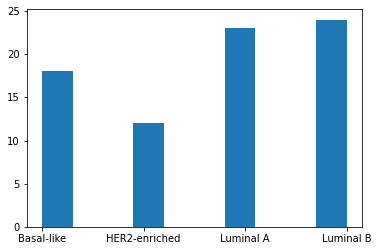

In [11]:
plt.hist(merged['PAM50 mRNA'])
# plt.savefig('figure1.pdf',format='pdf')

In [12]:
pd.set_option('display.max_columns',None)
data_clinical.head()

Complete TCGA ID  Gender  Age at Initial Pathologic Diagnosis ER Status  \
1      TCGA-A2-A0CM  FEMALE                                   40  Negative   
10     TCGA-A2-A0D2  FEMALE                                   45  Negative   
31     TCGA-A2-A0EQ  FEMALE                                   64  Negative   
55     TCGA-A2-A0EV  FEMALE                                   80  Positive   
61     TCGA-A2-A0EX  FEMALE                                   46  Positive   

   PR Status HER2 Final Status Tumor Tumor--T1 Coded Node Node-Coded  \
1   Negative          Negative    T2         T_Other   N0   Negative   
10  Negative          Negative    T2         T_Other   N0   Negative   
31  Negative          Positive    T2         T_Other   N0   Negative   
55  Positive          Negative    T1              T1   N0   Negative   
61  Positive          Negative    T3         T_Other   N0   Negative   

   Metastasis Metastasis-Coded AJCC Stage Converted Stage Survival Data Form  \
1          M0         Negative  Stage IIA       Stage IIA           followup   
10         M0         Negative  Stage IIB       Stage IIA           followup   
31         M0         Negative  Stage IIA       Stage IIA           followup   
55         M0         Negative   Stage IA         Stage I           followup   
61         M0         Negative  Stage IIB       Stage IIB         enrollment   

   Vital Status  Days to Date of Last Contact  Days to date of Death  \
1      DECEASED                           754                  754.0   
10       LIVING                          1027                    NaN   
31       LIVING                          2426                    NaN   
55       LIVING                           968                    NaN   
61       LIVING                           549                    NaN   

    OS event  OS Time     PAM50 mRNA  SigClust Unsupervised mRNA  \
1          1      754     Basal-like                         -12   
10         0     1027     Basal-like                         -12   
31         0     2426  HER2-enriched                          -5   
55         0      968      Luminal A                          -4   
61         0      549      Luminal A                          -7   

    SigClust Intrinsic mRNA  miRNA Clusters  methylation Clusters  \
1                       -13               4                     4   
10                      -13               4                     5   
31                       -2               5                     4   
55                        0               4                     2   
61                       -5               4                     4   

   RPPA Clusters  CN Clusters  Integrated Clusters (with PAM50)  \
1          Basal            4                                 2   
10         Basal            3                                 2   
31         Basal            4                                 4   
55         ReacI            3                                 3   
61         ReacI            4                                 3   

    Integrated Clusters (no exp)  Integrated Clusters (unsup exp)  
1                              1                                1  
10                             2                                2  
31                             1                                1  
55                             3                                4  
61                             1                                4

In [13]:
ER_positive = set(data_clinical[data_clinical['ER Status']=='Positive']['Complete TCGA ID'])
ER_negative = set(data_clinical[data_clinical['ER Status']=='Negative']['Complete TCGA ID'])
PR_positive = set(data_clinical[data_clinical['PR Status']=='Positive']['Complete TCGA ID'])
PR_negative = set(data_clinical[data_clinical['PR Status']=='Negative']['Complete TCGA ID'])
HER2_positive = set(data_clinical[data_clinical['HER2 Final Status']=='Positive']['Complete TCGA ID'])
HER2_negative = set(data_clinical[data_clinical['HER2 Final Status']=='Negative']['Complete TCGA ID'])
len(PR_negative)

34

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

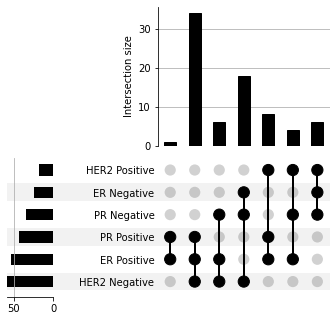

In [14]:
from upsetplot import plot
set_names = ['ER Positive', 'ER Negative', 
             'PR Positive', 'PR Negative',
            'HER2 Positive', 'HER2 Negative']
sets = [ER_positive, ER_negative, PR_positive, PR_negative, HER2_positive, HER2_negative]
all_elems = list(set().union(*sets))
df = pd.DataFrame([[e in st for st in sets] for e in all_elems], columns = set_names)
df_up = df.groupby(set_names).size()
plot(df_up, orientation='horizontal')

# FIGURE 2 .PY

In [15]:
import numpy as np

In [16]:
data = merged
data = data.dropna(axis='columns')
data.reset_index()
data_features = data[data.columns[:-29]]


In [17]:
from sklearn.preprocessing import StandardScaler
x = data_features.values
x = StandardScaler().fit_transform(x) # normalizing the features

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc = pca.fit_transform(x)


In [19]:
principal_df = pd.DataFrame(data = pc
             , columns = ['principal component 1', 'principal component 2'])
principal_df

principal component 1  principal component 2
0              -22.823943             -42.283848
1               -3.154133             -42.361431
2              -27.032954             -21.308331
3               58.687423              -3.823346
4               16.878494              -0.887250
..                    ...                    ...
72             -27.558304              13.743058
73              21.710460             -36.005061
74              35.444554              34.001299
75             -40.879415             -20.888582
76             -17.148142             -12.950759

[77 rows x 2 columns]

In [20]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.10722628 0.07808106]


In [21]:
# plt.figure()
# plt.figure(figsize=(10,10))
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=14)
# plt.xlabel('Principal Component - 1',fontsize=20)
# plt.ylabel('Principal Component - 2',fontsize=20)
# plt.title("Principal Component Analysis",fontsize=20)
# targets = ['FEMALE', 'MALE']
# colors = ['r', 'g']
# for target, color in zip(targets,colors):
#     indicesToKeep = data['Gender'] == target
#     plt.scatter(principal_df.loc[indicesToKeep, 'principal component 1']
#                , principal_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

# plt.legend(targets,prop={'size': 15})


# FIGURE 3 .PY

In [22]:
data.head()
data = data.reset_index()
data

Complete TCGA ID  NP_958782  NP_958785  NP_958786  NP_000436  NP_958781  \
0      TCGA-A2-A0CM   0.683404   0.694424   0.698098   0.687077   0.687077   
1      TCGA-A2-A0D2   0.107491   0.104164   0.107491   0.097512   0.104164   
2      TCGA-A2-A0EQ  -0.912670  -0.927979  -0.927979  -0.931806  -0.927979   
3      TCGA-A2-A0EV   0.452986   0.472590   0.472590   0.458587   0.472590   
4      TCGA-A2-A0EX   1.185108   1.192612   1.188860   1.185108   1.200116   
..              ...        ...        ...        ...        ...        ...   
72     TCGA-C8-A138   2.765081   2.779709   2.779709   2.797995   2.787023   
73     TCGA-D8-A142   0.538596   0.542211   0.542211   0.534981   0.542211   
74     TCGA-E2-A154   0.862659   0.870186   0.870186   0.866423   0.870186   
75     TCGA-E2-A158  -1.086529  -1.095492  -1.095492  -1.095492  -1.095492   
76     TCGA-E2-A15A   2.180123   2.180123   2.180123   2.180123   2.180123   

    NP_958780  NP_958783  NP_958784  NP_112598  NP_001611  NP_076965  \
0    0.698098   0.698098   0.698098  -2.652150  -0.984373  -0.547225   
1    0.104164   0.104164   0.104164  -0.880454  -1.512473  -1.406028   
2   -0.927979  -0.927979  -0.927979  -3.071151  -2.278943  -2.236845   
3    0.472590   0.472590   0.472590  -0.742871   1.811277   1.956909   
4    1.188860   1.188860   1.192612   1.046289   2.138081   1.732880   
..        ...        ...        ...        ...        ...        ...   
72   2.779709   2.783366   2.783366   2.205538   0.749997  -0.156974   
73   0.542211   0.542211   0.542211  -0.148205   0.267490   0.159048   
74   0.870186   0.870186   0.870186   1.920171   2.349197   1.581466   
75  -1.093252  -1.093252  -1.093252   0.096627  -1.149272  -1.270277   
76   2.180123   2.180123   2.180123   1.911711   0.896216   0.811219   

    NP_001367  NP_036222  NP_001138241  NP_001714  NP_002464  NP_001073936  \
0    0.654015  -0.672124     -1.436216  -0.150485  -0.308446      0.136049   
1    0.077553   0.493355     -0.594383  -0.002281   0.932442     -1.595633   
2   -0.598849  -1.471426     -1.750804  -2.056971  -1.215011      1.272601   
3   -0.247164  -1.022931     -0.109935   0.024494   0.002089     -1.272184   
4    0.187113  -0.687070      0.093317   0.734885   1.151341      0.273406   
..        ...        ...           ...        ...        ...           ...   
72   1.507025  -1.305315     -0.504402  -0.182574   1.254682      0.464740   
73   1.203708   0.007229      5.675142   5.187152   2.262827     -1.301307   
74   0.064821   0.395999     -1.523327  -2.343745   0.418580     -2.776535   
75   0.437233   0.448437      0.629944   0.027162  -0.490469      0.172815   
76  -0.275852  -1.796857     -0.074543  -0.150593   0.377285     -1.206349   

    NP_061198  NP_001074248  NP_001074419  NP_056009  NP_036355  NP_001155291  \
0   -1.590504     -0.716207     -0.705186  -1.223152  -1.910100     -1.902753   
1   -1.213096     -0.295005     -0.295005   0.436806  -0.361534     -0.408103   
2   -1.414020     -1.215011     -1.306861  -0.537615   0.974087      0.931989   
3   -0.448808      4.158181      4.107770   1.223151  -0.485215     -0.474013   
4    1.725376      1.035034      1.046289   3.586299   0.138339      0.138339   
..        ...           ...           ...        ...        ...           ...   
72   2.073881     -0.387373     -0.387373   1.108397  -0.054574     -0.083831   
73  -0.975980      1.189249      1.189249   2.913480   1.720616      1.709772   
74   1.442221      2.443281      2.435754   1.634153  -0.789467     -0.759360   
75  -1.510045     -0.445653     -0.463579   0.201946   0.172815      0.159370   
76  -0.378743     -0.284799     -0.284799   2.036970   0.806746      0.806746   

    NP_002462  NP_000248  NP_036467  NP_004989  NP_001243024  NP_149043  \
0   -1.054170  -1.054170   0.598913   0.867079     -0.701512   1.124226   
1    1.018928   1.161964   1.218513   2.236396      0.689613   1.391487   
2   -1.842654  -1.525005   0.461257  -0.610330     -1.984257   2.3

In [23]:
data_markers = data.drop(data[data['HER2 Final Status'] == 'Equivocal'].index)
x_markers = data_markers[['ER Status', 'PR Status', 'HER2 Final Status']]
x_pam50 = data[data.columns[data.columns.isin(list(list_pam50['RefSeqProteinID']))]]
x_all = data[data.columns[1:-29]]

y_markers = data_markers['PAM50 mRNA']
y = data['PAM50 mRNA']

In [24]:
y=y.replace(['Luminal B'],0)
y=y.replace(['Luminal A'],1)
y=y.replace(['Basal-like'],2)
y=y.replace(['HER2-enriched'],3)
y = list(y)

In [25]:
x_markers = x_markers.replace(['Negative'],0)
x_markers = x_markers.replace(['Positive'],1)


In [26]:
from sklearn.model_selection import train_test_split

X_train_markers, X_test_markers, y_train_markers, y_test_markers = \
train_test_split(x_markers, y_markers, test_size=0.3)

X_train_pam50, X_test_pam50, y_train_pam50, y_test_pam50 = \
train_test_split(x_pam50, y, test_size=0.3)

X_train_all, X_test_all, y_train_all, y_test_all = \
train_test_split(x_all, y, test_size=0.3)


In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree



# clf = DecisionTreeClassifier(random_state=0)
clf = LogisticRegression(max_iter=1000)

In [28]:
clf = clf.fit(X_train_markers, y_train_markers)
clf.score(X_test_markers, y_test_markers)

0.6086956521739131

In [29]:
clf = clf.fit(X_train_pam50, y_train_pam50)
clf.score(X_test_pam50, y_test_pam50)

0.625

In [30]:
clf = clf.fit(X_train_all, y_train_all)
clf.score(X_test_all,y_test_all)

0.5

# FIGURE 3+4 .PY

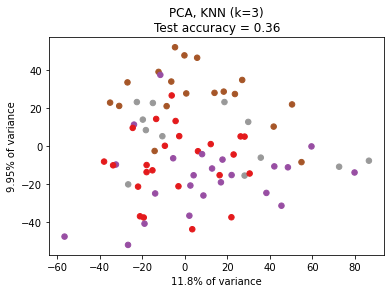

In [31]:
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

n_neighbors = 3
random_state = 0

X = np.asarray(data[data.columns[1:-29]])
y = np.asarray(y)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=random_state
)

dim = len(X[0])
n_classes = len(np.unique(y))

# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=random_state))

# Use a nearest neighbor classifier to evaluate the methods
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

plt.figure()

# Fit the method's model
pca.fit(X_train, y_train)

# Fit a nearest neighbor classifier on the embedded training set
knn.fit(pca.transform(X_train), y_train)

# Compute the nearest neighbor accuracy on the embedded test set
acc_knn = knn.score(pca.transform(X_test), y_test)

# Embed the data set in 2 dimensions using the fitted model
X_embedded = pca.transform(X)
variance_explained = pca[1].explained_variance_ratio_
pc1=round(variance_explained[0]*100,2)
pc2=round(variance_explained[1]*100,2)

# Plot the projected points and show the evaluation score
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30, cmap="Set1")
plt.title(
    "{}, KNN (k={})\nTest accuracy = {:.2f}".format('PCA', n_neighbors, acc_knn)
)
plt.xlabel("{}% of variance".format(pc1))
plt.ylabel("{}% of variance".format(pc2))
plt.show()

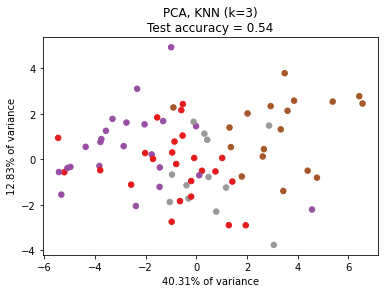

In [32]:
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

n_neighbors = 3
random_state = 0

X = np.asarray(x_pam50)
y = np.asarray(y)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=random_state
)

dim = len(X[0])
n_classes = len(np.unique(y))

# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=random_state))

# Use a nearest neighbor classifier to evaluate the methods
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

plt.figure()

# Fit the method's model
pca.fit(X_train, y_train)

# Fit a nearest neighbor classifier on the embedded training set
knn.fit(pca.transform(X_train), y_train)

# Compute the nearest neighbor accuracy on the embedded test set
acc_knn = knn.score(pca.transform(X_test), y_test)

# Embed the data set in 2 dimensions using the fitted model
X_embedded = pca.transform(X)
variance_explained = pca[1].explained_variance_ratio_
pc1=round(variance_explained[0]*100,2)
pc2=round(variance_explained[1]*100,2)

# Plot the projected points and show the evaluation score
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30, cmap="Set1")
plt.title(
    "{}, KNN (k={})\nTest accuracy = {:.2f}".format('PCA', n_neighbors, acc_knn)
)
plt.xlabel("{}% of variance".format(pc1))
plt.ylabel("{}% of variance".format(pc2))
plt.show()